In [1]:
from helper.dataset_reader import read_tsv
from langid_crf import *

In [2]:
langid = LanguageIdentifier()

In [3]:
merged_data = read_tsv('../dataset/ijelid-100722.tsv')

train_data = read_tsv('../dataset/14-07-22/train.tsv')
val_data = read_tsv('../dataset/14-07-22/val.tsv')
test_data = read_tsv('../dataset/14-07-22/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [langid.sent2features(s) for s in data]
	y = [langid.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 2890 sentences
Val set: 723 sentences
Test set: 1781 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.008092215462248482,  # Coefficient for Lasso (L1) regularization for
    c2=0.021144788156748907,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.008092215462248482,
    c2=0.021144788156748907, keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

          ID     0.9489    0.9749    0.9618     22302
          JV     0.9114    0.9133    0.9124      4913
          EN     0.9307    0.9179    0.9243      5018
   MIX-ID-EN     0.9680    0.9003    0.9329       973
   MIX-ID-JV     0.9611    0.8821    0.9199       280
   MIX-JV-EN     0.9409    0.8628    0.9002       277
           O     0.9621    0.9207    0.9409     10175

    accuracy                         0.9460     43938
   macro avg     0.9462    0.9103    0.9275     43938
weighted avg     0.9462    0.9460    0.9458     43938



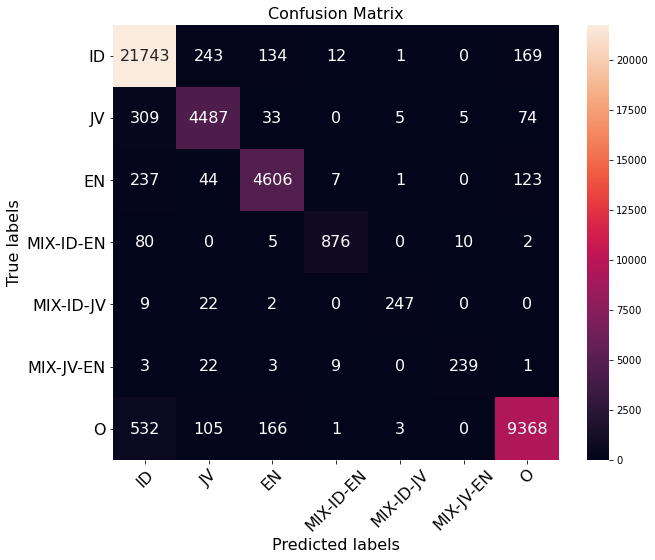

In [12]:
print('\n Evaluation on the test data')
langid.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
langid.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
langid.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
O          -> O          1.13058
O          -> ID         0.87498
ID         -> O          0.82448
JV         -> O          0.78009
EN         -> O          0.76182
O          -> JV         0.60419
JV         -> JV         0.58015
EN         -> EN         0.53508
O          -> EN         0.41321
ID         -> ID         0.40425
MIX-JV-EN  -> O          0.00074
EN         -> ID         -0.01234
O          -> MIX-ID-EN  -0.04897
ID         -> EN         -0.08393
JV         -> ID         -0.11243
ID         -> MIX-ID-EN  -0.18605
MIX-ID-JV  -> O          -0.23452
ID         -> JV         -0.29531
MIX-ID-EN  -> O          -0.31573
JV         -> EN         -0.37105

Top unlikely transitions:
O          -> MIX-ID-JV  -0.71390
O          -> MIX-JV-EN  -0.72018
MIX-ID-EN  -> MIX-ID-EN  -0.73449
JV         -> MIX-JV-EN  -0.81288
ID         -> MIX-ID-JV  -0.90874
EN         -> MIX-JV-EN  -0.93005
MIX-ID-JV  -> EN         -0.93457
MIX-JV-EN  -> ID         -0.98664
JV     

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,EN,ID,JV,MIX-ID-EN,MIX-ID-JV,MIX-JV-EN,O
EN,0.535,-0.012,-0.631,-0.406,-1.941,-0.93,0.762
ID,-0.084,0.404,-0.295,-0.186,-0.909,-1.415,0.824
JV,-0.371,-0.112,0.58,-1.704,-1.004,-0.813,0.78
MIX-ID-EN,-0.54,-0.384,-1.456,-0.734,-1.665,-2.587,-0.316
MIX-ID-JV,-0.935,-0.594,-0.541,-2.78,-1.898,-0.541,-0.235
MIX-JV-EN,-0.461,-0.987,-0.436,-1.596,-1.566,-1.368,0.001
O,0.413,0.875,0.604,-0.049,-0.714,-0.72,1.131


In [15]:
eli5.show_weights(model, targets=['ID','EN','JV'])

In [16]:
eli5.show_weights(model, targets=['MIX-ID-EN','MIX-ID-JV','MIX-JV-EN','O'])

In [18]:
## Error Analysis
crf_model = pickle.load(open('model/crf_model_split.pkl','rb'))